
# Mask on face detection <a class="anchor" id="section_0"></a>

POIDVIN Hugo, LAY Frédéric, NGUYEN VAN NGUYEN Vincent, LECORFF Erwann

This notebook contains a project which aim to detect the presence or not of a face mask on human faces.
The work will take the form of a classification algorithm which will differentiate photos between 2 categories :
-   People wearing a mask
-   People **NOT** wearing a mask


Data from kaggle : [Here](https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset)


<p align="center">
  <img width="300" height="300" src="https://user-images.githubusercontent.com/70579768/156454012-af770558-93c0-4364-9d6e-ccb8a4fe5e93.jpg">
</p>


### Table of Contents

* [Introduction](#section_0)
* [Imports](#section_1)
* [Sampling](#section_2)
* [Dataset setup](#section_3)
* [Model creation](#section_4)
* [Model training](#section_5)
* [Results](#section_6)



# Imports <a class="anchor" id="section_1"></a>

In [240]:
import os
from PIL import ImageFont
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, RandomRotation, RandomFlip, BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import visualkeras

# Sampling <a class="anchor" id="section_2"></a>

Initializing paths to our differents images :

In [241]:
#paths initialization
Test_path_Mask = Path("./New Masks Dataset/Test/Mask")
Test_path_Non_Mask = Path("./New Masks Dataset/Test/Non Mask")
Train_path_Mask = Path("./New Masks Dataset/Train/Mask")
Train_path_Non_Mask = Path("./New Masks Dataset/Train/Non Mask")
Validation_path_Mask = Path("./New Masks Dataset/Validation/Mask")
Validation_path_Non_Mask = Path("./New Masks Dataset/Validation/Non Mask")

Collecting 2 photos, one face with mask and one without :

In [242]:
#Collecting one masked face image :
Test_mask_img_list = os.listdir(Test_path_Mask)
masked_image = load_img(str(Test_path_Mask) + "/" + Test_mask_img_list[0])
#Collecting one unmasked face image :
Test_Non_mask_img_list = os.listdir(Test_path_Non_Mask)
Unmasked_image = load_img(str(Test_path_Non_Mask) + "/" + Test_Non_mask_img_list[0])

Showing our 2 pictures :

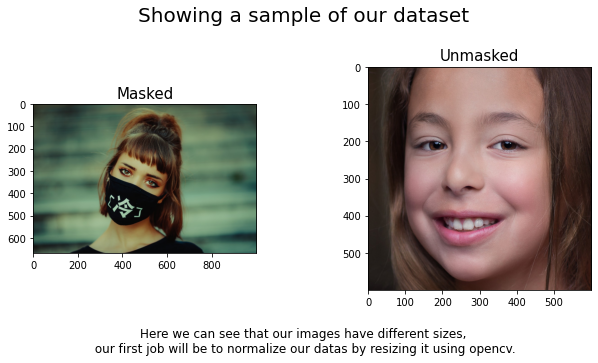

In [243]:
#creating subplot using labels
fig, ax = plt.subplot_mosaic([['Masked', 'Unmasked']], figsize=(10, 5))

ax['Masked'].imshow(masked_image)
ax['Unmasked'].imshow(Unmasked_image)
ax['Masked'].set_title('Masked', fontsize="15")
ax['Unmasked'].set_title('Unmasked', fontsize="15")

fig.suptitle('Showing a sample of our dataset', fontsize="20")
plt.subplots_adjust(wspace=0.5)
fig.supxlabel(
    'Here we can see that our images have different sizes,\n our first job will be to normalize our datas by resizing it using opencv.')
plt.show()

# Dataset setup <a class="anchor" id="section_3"></a>

Checking the actual dataset distribution :

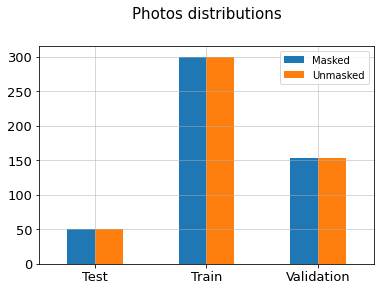

In [260]:
#creating a dict to facilitate the dataframe creation and plotting
data = {'Masked': [len(os.listdir(Test_path_Mask)),
                   len(os.listdir(Train_path_Mask)),
                   len(os.listdir(Validation_path_Mask))],
        'Unmasked': [len(os.listdir(Test_path_Non_Mask)),
                     len(os.listdir(Train_path_Non_Mask)),
                     len(os.listdir(Validation_path_Non_Mask))]}

df = pd.DataFrame(data)
df.index = ['Test', 'Train', 'Validation']
ax = df.plot(kind="bar", fontsize=13)
ax.set_title("Photos distributions", fontsize=15, y=11 / 10)
plt.xticks(rotation=0)
plt.grid(linewidth=0.5)

we can see that our target distribution is totaly balanced, but the size of the Train dataset has to be increased.

Initializing our differents sets :

we need to normalize the size of our images to send it to our CNN, default input shape used in VGG16 is 224*224, so we are using this shape to open our datas

In [245]:
X_train = []
y_train = []
X_test = []
y_test = []
X_valid = []
y_valid = []

dim = 224  # initializing the dimension of our photos, final dimension will be dim*dim, VGG16 default dim is 224*224*3

category = {'Non Mask': 0, 'Mask': 1}  #creating a dict to affect a boolean target to each photo

directory = ["./New Masks Dataset/Train", "./New Masks Dataset/Test", "./New Masks Dataset/Validation"]

for subdirectory in directory:
    for item in os.listdir(subdirectory):  #looping through the subdirectory
        path = os.path.join(subdirectory, item)  #adding "Mask" or "Non Mask" to the subdirectory path
        for image in os.listdir(path):  #looping through "/subdirectory/Mask" then through "/subdirectory/Non Mask"
            img = load_img(os.path.join(path, image), target_size=(dim, dim))
            if subdirectory == "./New Masks Dataset/Train":
                X_train.append(img)
                y_train.append(category[item])
            elif subdirectory == "./New Masks Dataset/Test":
                X_test.append(img)
                y_test.append(category[item])
            else:
                X_valid.append(img)
                y_valid.append(category[item])


Showing our 2 resized pictures :

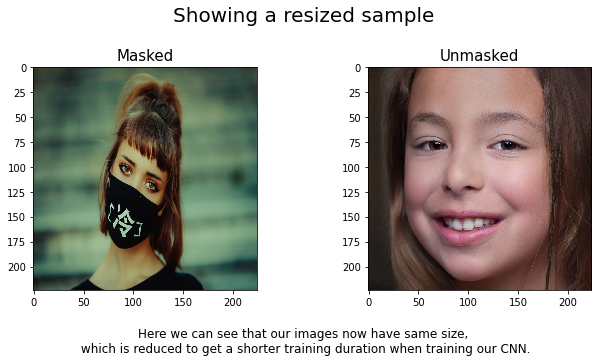

In [246]:
fig, ax = plt.subplot_mosaic([['Masked', 'Unmasked']], figsize=(10, 5))

ax['Masked'].imshow(X_test[0])
ax['Unmasked'].imshow(X_test[50])

ax['Masked'].set_title('Masked', fontsize="15")
ax['Unmasked'].set_title('Unmasked', fontsize="15")

fig.suptitle('Showing a resized sample', fontsize="20")
plt.subplots_adjust(wspace=0.5)
fig.supxlabel(
    'Here we can see that our images now have same size,\n which is reduced to get a shorter training duration when training our CNN.')
plt.show()

Showing our 2 preprocessed pictures :

In [247]:
X_train = list(map(img_to_array, X_train))
X_test = list(map(img_to_array, X_test))
X_valid = list(map(img_to_array, X_valid))

for item in [X_train, X_test, X_valid]:
    item = list(map(preprocess_input, item))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


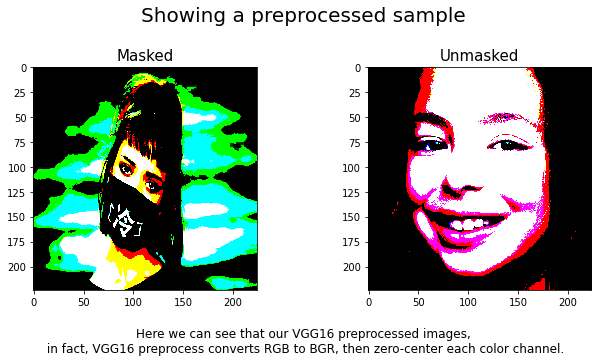

In [248]:
fig, ax = plt.subplot_mosaic([['Masked', 'Unmasked']], figsize=(10, 5))

ax['Masked'].imshow(X_test[0])
ax['Unmasked'].imshow((X_test[50]))

ax['Masked'].set_title('Masked', fontsize="15")
ax['Unmasked'].set_title('Unmasked', fontsize="15")

fig.suptitle('Showing a preprocessed sample', fontsize="20")
plt.subplots_adjust(wspace=0.5)
fig.supxlabel(
    'Here we can see that our VGG16 preprocessed images,\n in fact, VGG16 preprocess converts RGB to BGR, then zero-center each color channel.')
plt.show()

Data augmentation : Rotating image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


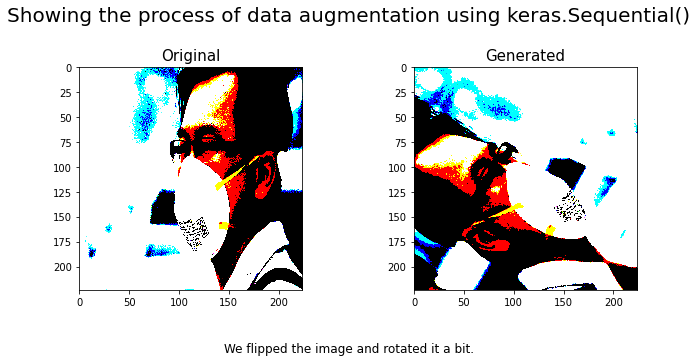

In [249]:
datagen = tf.keras.Sequential([
    RandomRotation(0.2),
    RandomFlip(mode='horizontal')
])
for i in range(X_train.__len__()):
    image = X_train[i]
    label = y_train[i]

    rotate = datagen(image, training = True)

    X_train.append(rotate)
    y_train.append(label)


fig, ax = plt.subplot_mosaic([['Original', 'Generated']], figsize=(10, 5))

ax['Original'].imshow(X_train[0])
ax['Generated'].imshow((X_train[600]))

ax['Original'].set_title('Original', fontsize="15")
ax['Generated'].set_title('Generated', fontsize="15")

fig.suptitle('Showing the process of data augmentation using keras.Sequential()', fontsize="20")
plt.subplots_adjust(wspace=0.5)
fig.supxlabel(
    'We flipped the image and rotated it a bit.')
plt.show()

# Model creation <a class="anchor" id="section_4"></a>

Instancing VGG16 model without output part of the model :

<em>note that we send our resized images shape to the input_shape parameter of VGG16 model</em>

In [250]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(dim, dim, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Here is a layered representation of our <b> vgg16 base model </b>:

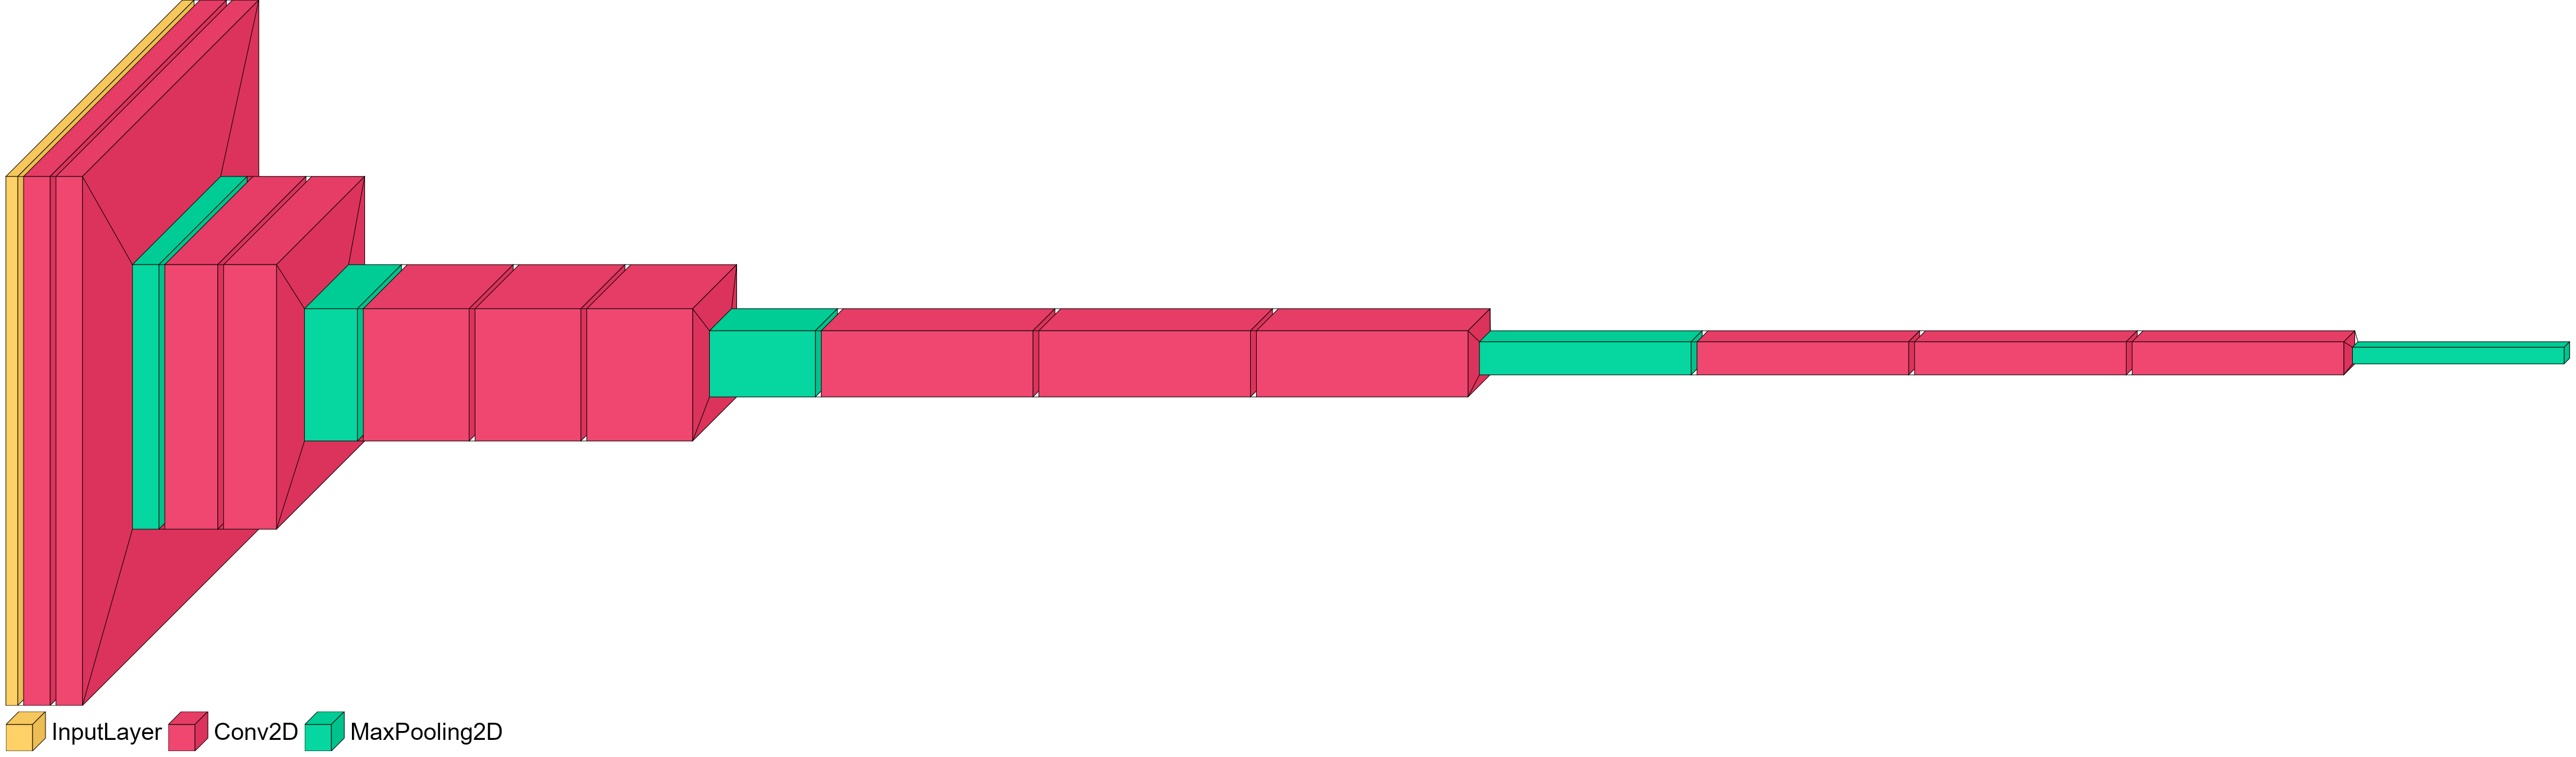

In [251]:
visualkeras.layered_view(vgg16, scale_z=0.7, legend=True, font=(ImageFont.truetype("arial.ttf", 40)))

then we add some layers to finally get our <b> complete model </b> architecture :

- note the number of non-trainable params which is equal to vgg16 params number

- note we added a BatchNormalization() layer after each conv2d layer to try to normalize a bit the network (to get faster training and reduce overfitting a bit)

- note we added Dropout() layers next to our Dense() layers to try to reduce overfitting)

In [262]:
model = Sequential()

for layer in vgg16.layers:
    layer.trainable = False
    model.add(layer)
    if 'conv' in layer.name :
        model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_177 (Ba  (None, 224, 224, 64)     256       
 tchNormalization)                                               
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_178 (Ba  (None, 224, 224, 64)     256       
 tchNormalization)                                               
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)   

Here is a layered representation of our <b> complete </b>  model :

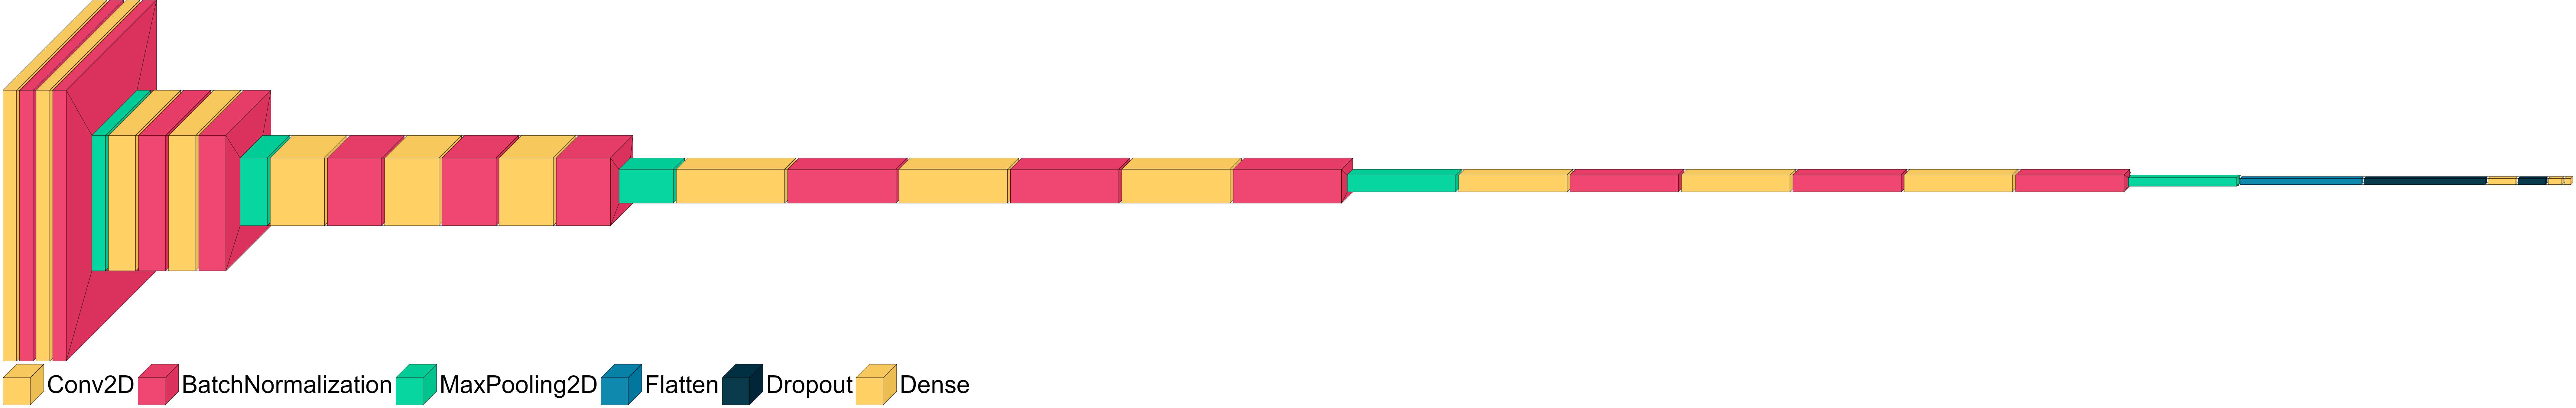

In [265]:
visualkeras.layered_view(model, scale_z=0.7, legend=True, font=(ImageFont.truetype("arial.ttf", 80)))

# Model training <a class="anchor" id="section_5"></a>

In [254]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [263]:
# converting our lists into array to use it for training/testing
y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)

Showing that we are going to use a <b>GPU</b> to train our model :

In [256]:
print("physical devices list : ", tf.config.get_visible_devices())

tf.debugging.set_log_device_placement(True)

physical devices list :  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Training using <b>GPU</b> :

In [257]:
with tf.device('/GPU:0'):
    training = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/10
150/150 [==============================] - 22s 143ms/step - loss: 0.6642 - accuracy: 0.8600 - val_loss: 0.2527 - val_accuracy: 0.9150
Epoch 2/10
150/150 [==============================] - 21s 137ms/step - loss: 0.3027 - accuracy: 0.9275 - val_loss: 0.0840 - val_accuracy: 0.9673
Epoch 3/10
150/150 [==============================] - 21s 142ms/step - loss: 0.2379 - accuracy: 0.9492 - val_loss: 0.3471 - val_accuracy: 0.9118
Epoch 4/10
150/150 [==============================] - 22s 148ms/step - loss: 0.1567 - accuracy: 0.9750 - val_loss: 0.1165 - val_accuracy: 0.9706
Epoch 5/10
150/150 [==============================] - 22s 147ms/step - loss: 0.1627 - accuracy: 0.9742 - val_loss: 0.1719 - val_accuracy: 0.9804
Epoch 6/10
150/150 [==============================] - 22s 147ms/step - loss: 0.1178 - accuracy: 0.9758 - val_loss: 0.1850 - val_accuracy: 0.9673
Epoch 7/10
150/150 [==============================] - 21s 140ms/step - loss: 0.1022 - accuracy: 0.9858 - val_loss: 0.1430 - val_ac

# Results <a class="anchor" id="section_6"></a>

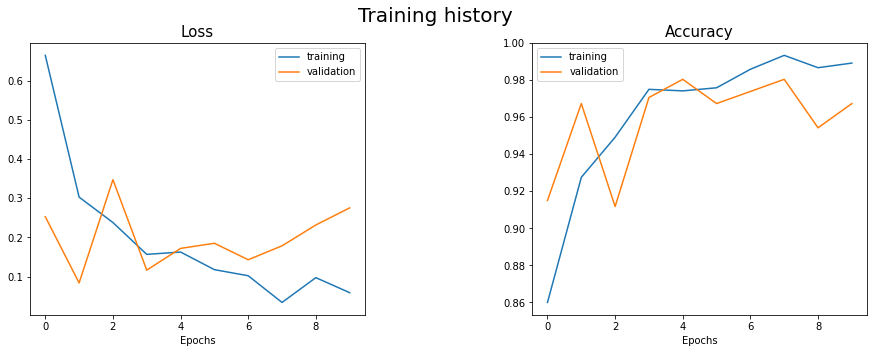

In [258]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(training.history['loss'])
ax[0].plot(training.history['val_loss'])
ax[0].legend(['training', 'validation'])

ax[1].plot(training.history['accuracy'])
ax[1].plot(training.history['val_accuracy'])
ax[1].legend(['training', 'validation'])

ax[0].set_title('Loss', fontsize="15")
ax[1].set_title('Accuracy', fontsize="15")
ax[0].set_xlabel("Epochs")
ax[1].set_xlabel("Epochs")

fig.suptitle('Training history', fontsize="20")
plt.subplots_adjust(wspace=0.5)
plt.show()

Here we can see the result of our training, the model seems to be a bit over fitted, even if we used BatchNormalization, Data Augmentation and Dropout to
try to reduce it, the problem is probably the size of our validation set, which is a little small.

However the validation accuracy is pretty good, the model learns well and now it can classify masked people and unmasked people with a global accuracy near to 98% !